In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
from matplotlib import pyplot

In [2]:
data2014 = pd.read_csv("Output/2014dataset.csv",low_memory=False)
data2015 = pd.read_csv("Output/2015dataset.csv",low_memory=False)
data2016 = pd.read_csv("Output/2016dataset.csv",low_memory=False)

In [3]:
states = data2014["STATE"].drop_duplicates().as_matrix()
print(states)

['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID' 'IL'
 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC' 'ND' 'NE'
 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT'
 'VA' 'WA' 'WI' 'WV' 'WY']


In [30]:
# weighted rigorous statistics
# group can be i for individual or sg for small group
# absval can be 1 for yes and 0 for no

# functions:
# def getmm(group) - returns member months column
# xbarybar(dataset, column_name, state, group, absval) - returns weighted avg of a column
# sigmaxsigmay(dataset, column_name, state, group, absval) - returns weighted std of a column
# covxy(dataset, column_name1, column_name2, state, group, absval1, absval2) - returns weighted cov of two columns
# covspecial(dataset, column_name1, yi, ybar, state, group, absval1) - returns weighted cov of one column and one state measure
# r(dataset, column_name1, column_name2, state, group, absval1, absval2) - returns weighted r of two columns
# rspecial(dataset, column_name1, yi, ybar, sigmay, state, group, absval1) - returns weighted r of one column and one state measure
# rsquared(dataset, column_name1, column_name2, state, group, absval1, absval2) - returns weighted r^2 of two columns

def getmm(group):
    if group == "i":
        return "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"
    elif group == "sg":
        return "7.4Membermonths7HealthInsuranceSMALLGROUPTotalasof3/31/15"
    else:
        return ""

def xbarybar(dataset, column_name, state, group, absval):
    if state == "ALL":
        temp = dataset
    else:
        temp = dataset.where(dataset["STATE"] == state).dropna(how='all')
    mm = getmm(group)
    sum_mm = sum(temp[mm].convert_objects(convert_numeric=True).dropna())
    if sum_mm == 0:
        return
    numerator = 0
    denominator = 0
    for index, row in temp.iterrows():
        if (pd.notnull(row[column_name])) and (pd.notnull(row[mm])):
            ratio = row[mm] / sum_mm
            denominator = denominator + ratio
            if absval == 1:
                numerator = numerator + (abs(row[column_name]) * ratio)
            else:
                numerator = numerator + (row[column_name]  * ratio)
    #print(str(column_name) + " " + str(numerator / denominator))
    return numerator / denominator

def sigmaxsigmay(dataset, column_name, state, group, absval):
    if state == "ALL":
        temp = dataset
    else:
        temp = dataset.where(dataset["STATE"] == state).dropna(how='all')
    mm = getmm(group)
    sum_mm = sum(temp[mm].convert_objects(convert_numeric=True).dropna())
    if sum_mm == 0:
        return "-1"
    numerator = 0
    denominator = 0
    xbar = xbarybar(dataset, column_name, state, group, absval)
    for index, row in temp.iterrows():
        if (pd.notnull(row[column_name])) and (pd.notnull(row[mm])):
            ratio = row[mm] / sum_mm
            denominator = denominator + ratio
            if absval == 1:
                numerator = numerator + ((abs(row[column_name]) - abs(xbar))**2 * ratio)
            else:
                numerator = numerator + ((row[column_name] - xbar)**2 * ratio)
    return np.sqrt(numerator / denominator)

def covxy(dataset, column_name1, column_name2, state, group, absval1, absval2):
    if state == "ALL":
        temp = dataset
    else:
        temp = dataset.where(dataset["STATE"] == state).dropna(how='all')
    mm = getmm(group)
    sum_mm = sum(temp[mm].convert_objects(convert_numeric=True).dropna())
    if sum_mm == 0:
        return -1
    numerator = 0
    denominator = 0
    xbar = xbarybar(dataset, column_name1, state, group, absval1)
    ybar = xbarybar(dataset, column_name2, state, group, absval2)
    for index, row in temp.iterrows():
        if (pd.notnull(row[column_name2])) and (pd.notnull(row[column_name1])) and (pd.notnull(row[mm])):
            xi = row[column_name1]
            yi = row[column_name2]
            ratio = row[mm] / sum_mm
            denominator = denominator + ratio
            if absval1 == 1 and absval2 == 1:
                numerator = numerator + ((abs(xi) - xbar) * (abs(yi) - ybar) * ratio)
            elif absval1 == 1:
                numerator = numerator + ((abs(xi) - xbar) * (yi - ybar) * ratio)
            elif absval2 == 1:
                numerator = numerator + ((xi - xbar) * (abs(yi) - ybar) * ratio)
            else:
                numerator = numerator + ((xi - xbar) * (yi - ybar) * ratio)
    return numerator / denominator

def r(dataset, column_name1, column_name2, state, group, absval1, absval2):
    print(str(column_name1) + " vs " + str(column_name2) + " in " + str(state))
    cov = covxy(dataset, column_name1, column_name2, state, group, absval1, absval2)
    sigx = sigmaxsigmay(dataset, column_name1, state, group, absval1)
    sigy = sigmaxsigmay(dataset, column_name2, state, group, absval2)
    #print("Covariance: " + str(cov))
    #print("Std Column 1: " + str(sigx))
    #print("Std Column 2: " + str(sigy))
    r = cov / (sigx * sigy)
    print("r: " + str(r) + "\n")
    temp1 = dataset[[column_name1,column_name2]].dropna(how='any')
    print(len(temp1))
    #n1 = temp1.astype(bool).sum(axis=1)
    #print("n_1: " + str(n1))
    return r

def rsquared(dataset, column_name1, column_name2, state, group, absval1, absval2):
    return r(dataset, column_name1, column_name2, state, group, absval1, absval2)**2

In [5]:
def play(dataset):
    playground1 = pd.read_csv(dataset,low_memory=False)
    forprofit = playground1.where(playground1["Not-For-Profit:"] == 'Yes').dropna(how='all')
    nonprofit = playground1.where(playground1["Not-For-Profit:"] == 'No').dropna(how='all')
    

    forprofit["IndPremiumPMM"] = forprofit["1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15"] / forprofit["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    forprofit["IndCostsPMM"] = forprofit["2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15"] / forprofit["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    forprofit["IndRTPMM"] = forprofit["HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)"] / forprofit["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    forprofit["IndPremiumMinusCostsPMM"] = forprofit["IndPremiumPMM"] - forprofit["IndCostsPMM"]
    forprofit["IndCostsMinusPremiumsPMM"] = forprofit["IndCostsPMM"] - forprofit["IndPremiumPMM"]
    
    nonprofit["IndPremiumPMM"] = nonprofit["1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15"] / nonprofit["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    nonprofit["IndCostsPMM"] = nonprofit["2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15"] / nonprofit["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    nonprofit["IndRTPMM"] = nonprofit["HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)"] / nonprofit["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    nonprofit["IndPremiumMinusCostsPMM"] = nonprofit["IndPremiumPMM"] - nonprofit["IndCostsPMM"]
    nonprofit["IndCostsMinusPremiumsPMM"] = nonprofit["IndCostsPMM"] - nonprofit["IndPremiumPMM"]
    
    print("Statistics for " + dataset + "\n")
    print("For profit\n")
    r(forprofit, "IndPremiumPMM","IndRTPMM","ALL", "i", 0, 0)
    r(forprofit, "IndCostsPMM","IndRTPMM","ALL", "i", 0, 0)
    r(forprofit, "IndCostsPMM","IndPremiumPMM","ALL", "i", 0, 0)
    r(forprofit, "IndPremiumMinusCostsPMM","IndRTPMM","ALL", "i", 0, 0)
    print("Non profit\n")
    r(nonprofit, "IndPremiumPMM","IndRTPMM","ALL", "i", 0, 0)
    r(nonprofit, "IndCostsPMM","IndRTPMM","ALL", "i", 0, 0)
    r(nonprofit, "IndCostsPMM","IndPremiumPMM","ALL", "i", 0, 0)
    r(nonprofit, "IndPremiumMinusCostsPMM","IndRTPMM","ALL", "i", 0, 0)

In [8]:
play("Output/2014dataset.csv")
play("Output/2015dataset.csv")
play("Output/2016dataset.csv")

Statistics for Output/2014dataset.csv

For profit

IndPremiumPMM vs IndRTPMM in ALL
r: 0.198116013727

IndCostsPMM vs IndRTPMM in ALL
r: 0.263758583715

IndCostsPMM vs IndPremiumPMM in ALL
r: 0.571383709569

IndPremiumMinusCostsPMM vs IndRTPMM in ALL
r: -0.113468080951

Non profit

IndPremiumPMM vs IndRTPMM in ALL
r: 0.184622139508

IndCostsPMM vs IndRTPMM in ALL
r: 0.518360351743

IndCostsPMM vs IndPremiumPMM in ALL
r: 0.554277157824

IndPremiumMinusCostsPMM vs IndRTPMM in ALL
r: -0.502187253338

Statistics for Output/2015dataset.csv

For profit

IndPremiumPMM vs IndRTPMM in ALL
r: 0.220533457377

IndCostsPMM vs IndRTPMM in ALL
r: 0.50144135372

IndCostsPMM vs IndPremiumPMM in ALL
r: 0.398871094373

IndPremiumMinusCostsPMM vs IndRTPMM in ALL
r: -0.352115872961

Non profit

IndPremiumPMM vs IndRTPMM in ALL
r: 0.441218542245

IndCostsPMM vs IndRTPMM in ALL
r: 0.410054020912

IndCostsPMM vs IndPremiumPMM in ALL
r: 0.365309539255

IndPremiumMinusCostsPMM vs IndRTPMM in ALL
r: -0.313207273

In [ ]:
data2014 = pd.read_csv("Output/2014dataset.csv",low_memory=False)
data2015 = pd.read_csv("Output/2015dataset.csv",low_memory=False)
data2016 = pd.read_csv("Output/2016dataset.csv",low_memory=False)

In [52]:
def playmerged(dataset1, dataset2, dataset3):
    important_fields = ["HIOS ID","1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15",
    "2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15",
    "HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)",
    "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    playground1 = pd.read_csv(dataset1,low_memory=False)
    playground2 = pd.read_csv(dataset2,low_memory=False)
    playground3 = pd.read_csv(dataset3,low_memory=False)
    
    playground1 = playground1[important_fields]
    playground2 = playground2[important_fields]
    playground3 = playground3[important_fields]

    playground1 = playground1.merge(playground2, how='outer',on='HIOS ID',suffixes=('_2014', '_2015'))
    playground1 = playground1.merge(playground3, how='outer', on='HIOS ID') #unlabeled one is 2016

    playground1["IndPremiumPMM_2014"] = playground1["1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15_2014"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15_2014"]
    playground1["IndCostsPMM_2014"] = playground1["2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15_2014"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15_2014"]
    playground1["IndRTPMM_2014"] = playground1["HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)_2014"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15_2014"]
    playground1["IndLossPMM_2014"] = playground1["IndCostsPMM_2014"] - playground1["IndPremiumPMM_2014"]
    
    playground1["IndPremiumPMM_2015"] = playground1["1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15_2015"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15_2015"]
    playground1["IndCostsPMM_2015"] = playground1["2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15_2015"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15_2015"]
    playground1["IndRTPMM_2015"] = playground1["HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)_2015"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15_2015"]
    playground1["IndLossPMM_2015"] = playground1["IndCostsPMM_2015"] - playground1["IndPremiumPMM_2015"]
    
    playground1["IndPremiumPMM_2016"] = playground1["1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    playground1["IndCostsPMM_2016"] = playground1["2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    playground1["IndRTPMM_2016"] = playground1["HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)"] / playground1["7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15"]
    playground1["IndLossPMM_2016"] = playground1["IndCostsPMM_2016"] - playground1["IndPremiumPMM_2016"]
    
    playground1["DeltaLoss1615"] = playground1["IndLossPMM_2016"] - playground1["IndLossPMM_2015"]
    playground1["DeltaLoss1514"] = playground1["IndLossPMM_2015"] - playground1["IndLossPMM_2014"]
    
    temp1 = playground1.where(playground1["DeltaLoss1514"] > 0)
    temp2 = playground1.where(playground1["DeltaLoss1514"] < 0)
    
    print("Statistics")
    r(playground1, "IndLossPMM_2016","IndLossPMM_2015","ALL", "i", 0, 0)
    r(playground1, "IndLossPMM_2016","IndLossPMM_2014","ALL", "i", 0, 0)
    r(playground1, "IndLossPMM_2015","IndLossPMM_2014","ALL", "i", 0, 0)
    r(playground1, "DeltaLoss1615","DeltaLoss1514","ALL", "i", 0, 0)
    r(temp1, "DeltaLoss1615","DeltaLoss1514","ALL", "i", 0, 0)
    r(temp2, "DeltaLoss1615","DeltaLoss1514","ALL", "i", 0, 0)
    
    
    x = playground1["DeltaLoss1615"].dropna(how='any')
    y = playground1["DeltaLoss1514"].dropna(how='any')

    bins = np.linspace(-7500, 10000, 100)

    pyplot.hist(x, bins, alpha=0.5, label='loss 16-15')
    pyplot.hist(y, bins, alpha=0.5, label='loss 15-14')
    pyplot.legend(loc='upper right')
    pyplot.show()
    
    x = playground1["DeltaLoss1615"].dropna(how='any')
    y = playground1["DeltaLoss1514"].dropna(how='any')

    bins = np.linspace(-500, 500, 100)

    pyplot.hist(x, bins, alpha=0.5, label='loss 16-15')
    pyplot.hist(y, bins, alpha=0.5, label='loss 15-14')
    pyplot.legend(loc='upper right')
    pyplot.show()

Statistics
IndLossPMM_2016 vs IndLossPMM_2015 in ALL
r: -0.0263501719999

552
IndLossPMM_2016 vs IndLossPMM_2014 in ALL
r: 0.0294412436731

485
IndLossPMM_2015 vs IndLossPMM_2014 in ALL
r: 0.619989790882

617
DeltaLoss1615 vs DeltaLoss1514 in ALL
r: -0.844564529019

483
DeltaLoss1615 vs DeltaLoss1514 in ALL
r: -0.871881237167

255
DeltaLoss1615 vs DeltaLoss1514 in ALL
r: 0.494340053668

228


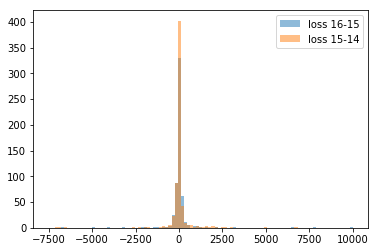

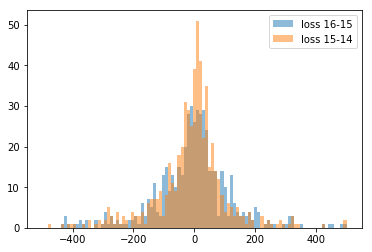

In [53]:
playmerged("Output/2014dataset.csv","Output/2015dataset.csv","Output/2016dataset.csv")

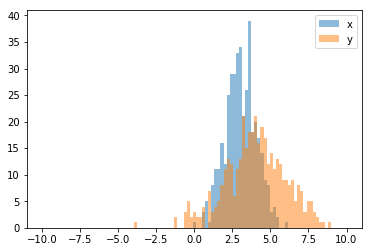

In [35]:


x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = np.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()